##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Image Generation with REST

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Imagen_REST.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

The `imagen-3.0-generate-002` model is Google's highest quality text-to-image model, featuring a number of new and improved capabilities. Imagen 3 can do the following:

* Generate images with fine detail, rich lighting, and few distracting artifact
* Understand prompts written in natural language
* Generate images in a wide range of formats and styles
* Render text effectively

This notebook is using the [REST API](https://ai.google.dev/api/generate-content). For the Python SDK, check out the [Get Started with Imagen](../quickstarts/Get_started_imagen.ipynb) Python guide.

<font color='red'>Image generation is a paid-only feature and won't work if you are on the free tier. Check the [pricing](https://ai.google.dev/pricing#imagen3) page for more details.</font>

## Set up the environment

To run this notebook, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you are running in a different environment, you can store your key in an environment variable. See [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) to learn more.

In [1]:
import os
from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

For this example you will also need to install `jq` to help with processing JSON API responses.

In [ ]:
!apt install -q jq

## Send Imagen request
In the next code block, you can change the image generation prompt and other optional settings related to the final output generated images.

The optional parameters are:
* *sampleCount*: How many images will be generated. Default is 4, valid values are 1-4.
* *aspectRatio*: aspect ratio of the images produced. Supported values are 1:1, 3:4, 4:3, 16:9, 9:16. Default is 1:1.
* *personGeneration*: Lets the model generate images with adults. Kids are always blocked. Supported values are "dont_allow" and "allow_adult". Default is "allow_adult".

The model is trained on long captions and will provide best results for longer and more descriptive prompts. Short prompts may result in low adherence and a more random output.

Check the [prompt guide](https://ai.google.dev/gemini-api/docs/imagen-prompt-guide) for more advices.

Note: A non-visible digital [SynthID](https://deepmind.google/technologies/synthid/) watermark is always added to generated images.

Note 2: Colab doesn't allow variables to be shared between cells, so you will store them in a new file named `vars.sh` to access later.

In [4]:
%%bash

SAMPLE_COUNT=3 # @param {type:"slider", min:1, max:4, step:1}
ASPECT_RATIO="1:1" # @param ["1:1", "3:4", "4:3", "16:9", "9:16"]
PERSON_GENERATION="allow_adult" # @param ["dont_allow", "allow_adult"]
PROMPT="a photorealistic single calico cat lounging in a soft cat bed by a window with the sun shining on them. Include shadows so only the cat is touched by the sun." # @param {type:"string"}

echo $SAMPLE_COUNT $ASPECT_RATIO $PERSON_GENERATION $PROMPT
# Colab doesn't allow sharing shell variables between cells, so save them.
cat >./vars.sh <<-EOF
  export SAMPLE_COUNT=${SAMPLE_COUNT}
  export ASPECT_RATIO="${ASPECT_RATIO}"
  export PERSON_GENERATION="${PERSON_GENERATION}"
  export PROMPT="${PROMPT}"
EOF

3 1:1 allow_adult a photorealistic single calico cat lounging in a soft cat bed by a window with the sun shining on them. Include shadows so only the cat is touched by the sun.


# Sending an image generation request

Now that you have your prompt and optional values, it's time to send an actual request to the image generation model. For the REST endpoint, this colab will use a `curl` command with a content-type of `application/json`. The response will contain an array of newly generated images in a base64 format.

In [5]:
%%bash
. vars.sh

curl "https://generativelanguage.googleapis.com/v1beta/models/imagen-4.0-fast:predict?key=${GOOGLE_API_KEY}" \
    -H 'Content-Type: application/json' \
    -X POST \
    -d '{
    "instances": [
        {
            "prompt": "'"${PROMPT}"'"
        }
    ],
    "parameters": {
        "sampleCount": '${SAMPLE_COUNT}',
        "personGeneration": "'${PERSON_GENERATION}'",
        "aspectRatio": "'${ASPECT_RATIO}'",
    }
}' 2>/dev/null >response.json

After the response has been received, you can count how many items were returned. This should match your sampleCount value if you used one. You can also retrieve the mime type of each image from the predictions results.

In [6]:
print("Number of predictions: ")
!jq '.[] | length' response.json
print("--")
print("Mime types: ")
!jq -C .predictions[].mimeType response.json

Number of predictions: 
3
--
Mime types: 
"image/png"
"image/png"
"image/png"


Now that you have your data and have reviewed it, it's time to do something with it. For this example you will loop through each item, retrieve the base64 encoded string, and convert them into a set of `png` images that are stored in the Colab local file directory.

In [7]:
%%bash
. vars.sh

# Iterate through predictions array
for i in $(seq 0 $(expr ${SAMPLE_COUNT} - 1)); do
  # Extract base64 encoded image data
  base64_data=$(jq -r ".predictions[$i].bytesBase64Encoded" response.json)

  # Decode base64 data and save as image
  echo "$base64_data" | base64 -d > "image${i}.png"
done

## Check the generated images

Finally, it's time to look at the images that were generated. One option is to just open them from Colba's files section on the side of the page. The next cell will use Python to display the images at half of their size for easy viewing.

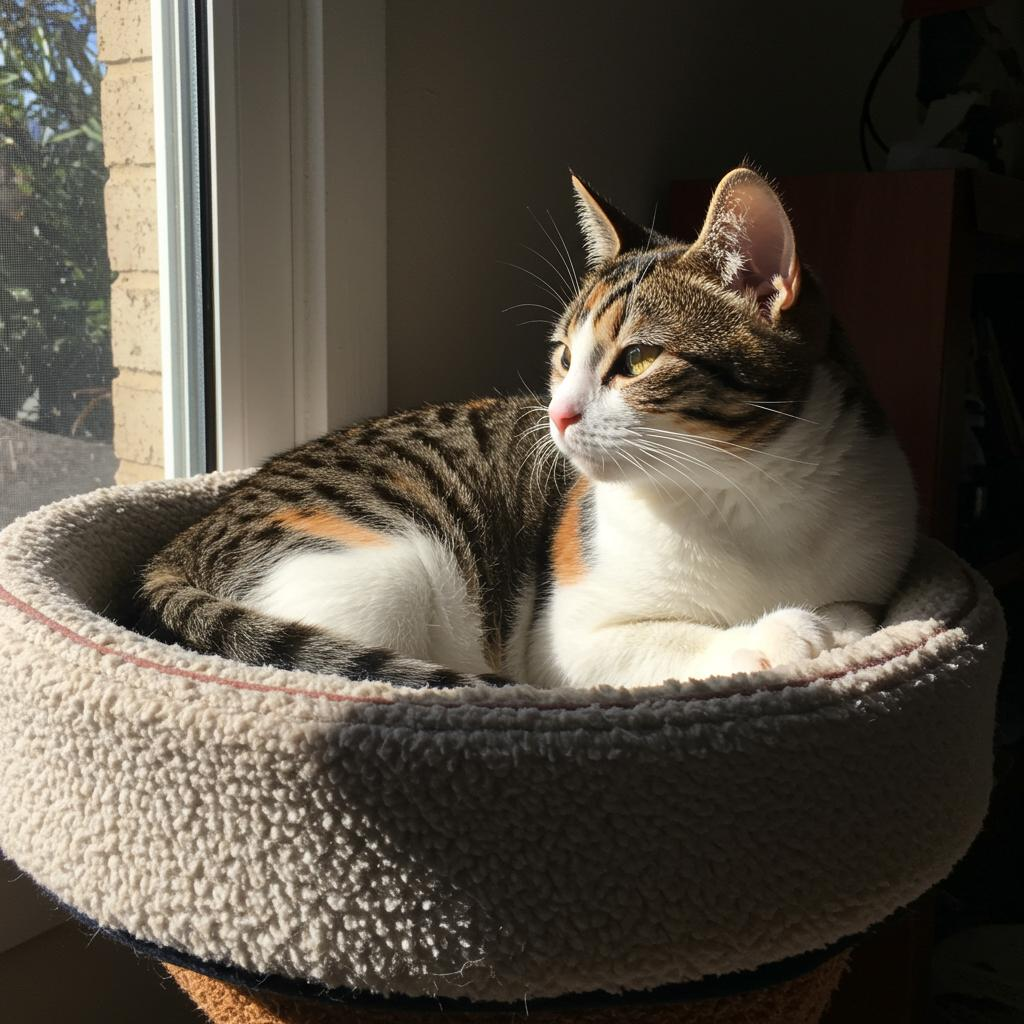

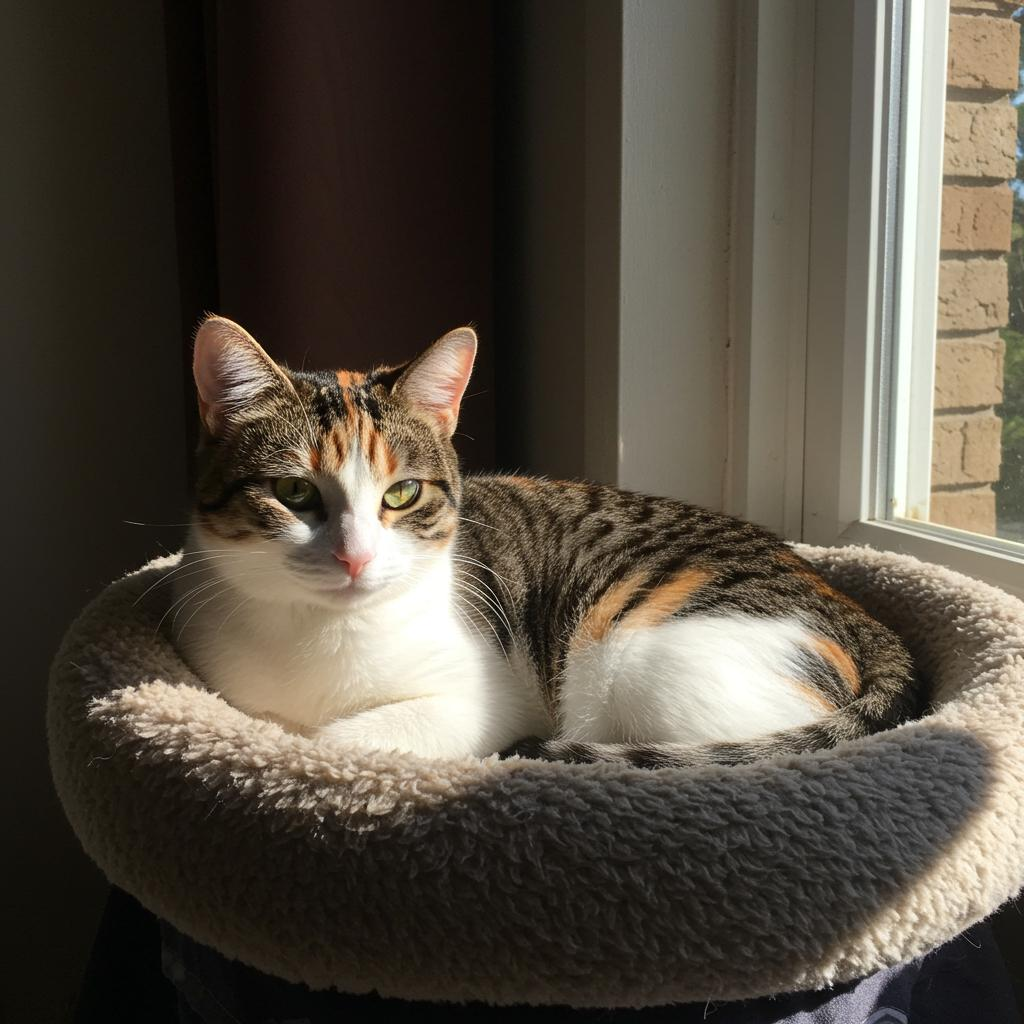

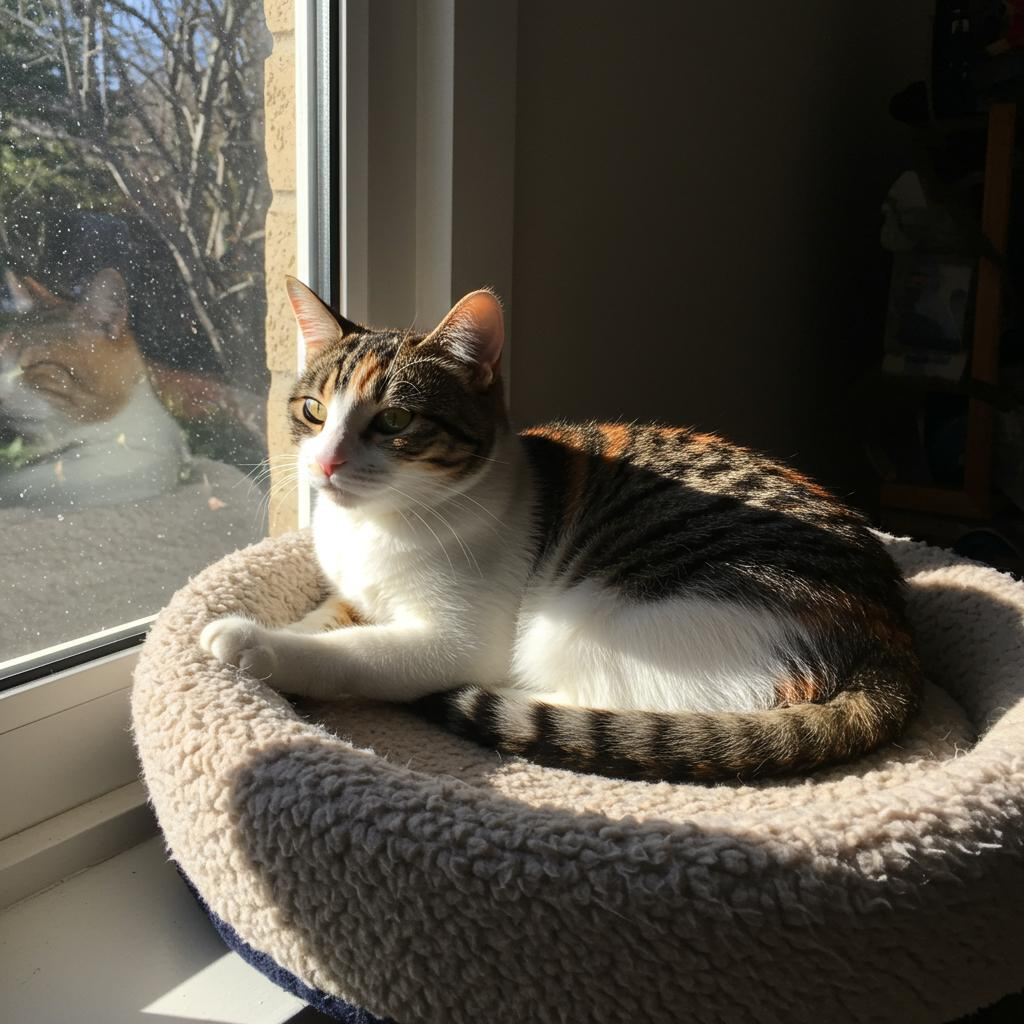

In [8]:
import os
from IPython.display import Image, display
from PIL import Image as PILImage

for i in range(4):
    filename = f"image{i}.png"
    if os.path.exists(filename):
        try:
            with PILImage.open(filename) as img:
                width, height = img.size # Get the original image size
                new_width = width // 2 # Cut it in half so you're not displaying images that are really large. Can change the value here for different proportions, or use '1' for original size.
                new_height = height // 2
                display(Image(filename, width=new_width, height=new_height))
        except FileNotFoundError:
            print(f"File not found: {filename}") # Shouldn't happen, but how many times that been said?
        except Exception as e:
            print(f"Error processing {filename}: {e}") # Handles other potential exceptions like corrupt image files.

## Next Steps
### Useful documentation references:

To improve your prompting skills, check the [prompt guide](https://ai.google.dev/gemini-api/docs/imagen-prompt-guide) for great advices on creating your prompts.

### Check those cool Imagen examples:
These examples are in Python but they will still give you ideas on how to use Imagen in creative ways:
*  [Illustrate a book](../examples/Book_illustration.ipynb): Use Gemini and Imagen to create illustration for an open-source book

### Continue your discovery of the Gemini API

Gemini is not only good at generating images, but also at understanding them. Check the [Spatial understanding](./Spatial_understanding.ipynb) guide for an introduction on those capabilities, and the [Video understanding](./Video_understanding.ipynb) one for video examples.